# Parameter estimation with MCMC - comparison across strains.

(c) 2017 the authors. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

In [48]:
import os
import glob
import pickle
import datetime
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.special
import numba
# Library to perform MCMC runs
import emcee
import matplotlib.gridspec as gridspec
import sys
sys.path.append(os.path.abspath('../'))
import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import seaborn as sns
import corner

mwc.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Generate a variable with the day that the script is run
today = str(datetime.datetime.today().strftime('%Y%m%d'))

# Defining the problem

In this notebook we will perform Bayesian parameter estimation of the dissociation constants of the inducer binding to the repressor in the active and inactive state, or $K_A$ and $K_I$, respectively. While the main text of the paper estimated these values from measurements of fold-change from a strain containing the O2 operator and $R=260$ per cell, here we consider this inference for each of the individual strains. Specifically, we make multiple estimates of $K_A$ and $K_I$ by applying parameter estimation using the fold-change measurements as a function of inducer concentration, $c$, for each combination of operator binding energy and LacI copy number considered. Following parameter estimation from each strain's dataset, we then compare the theoretical predictions with our experimental data in a similar manner to that of the main text. 

For details of the parameter estimation and the Bayesian approach that is applied here, see the 'MCMC_Parameter_estimation' notebook. 


In order to minimize the data frame parsing that the log-posterior has to do when performing the MCMC let's write a pre-processing function that will parse the data once such that the output can be feed to the log-posterior function.

In [71]:
def mcmc_pre_process(df):
    """
    Pre-process the tidy DataFrame to prepare it for the MCMC. This is done
    separately from the log-posterior calculation to speed up the process
    avoiding parsing the DataFrame every evaluation of the posterior.
    Parameteres
    -----------
    df : pandas DataFrame.
        A tidy pandas DataFrame as standardized in the project that contains
        at least the following columns:
        fold_change_A : the experimental fold-change from channel A in the
        flow cytometer.
    IPTG_uM : 1d-array
        Concentrations of the inducer in micromolar. 
    repressors : int
        The mean repressor copy number in copies per cell. 
    binding_energy : float
        The mean repressor binding energy

    Returns
    -------
    [rep_unique, eps_unique] : list
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
        After that we have all the repressor copy numbers for each of the RBS
        mutants. Followed by all the unique binding energies in the DataFrame.
        This variable indicates the position of each of these variables such
        that  the function is robust and it works for a DataFrame with 1 RBS 
        mutant and 1 energy as well as for multiple mutants and multiple enrgies.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change_A
        data[:, 1] : IPTG_uM
        data[:, 2] : repressors
        data[:, 3] : delta_repressors
        data[:, 4] : binding_energy
        data[:, 5] : delta_energy
    """
    # List the unique variables
    rep_unique = np.sort(df.repressors.unique())
    eps_unique = np.sort(df.binding_energy.unique())
    IPTG_unique = np.sort(df.IPTG_uM.unique())
    
    # determine the number of unique variables
    n_repressor = len(rep_unique)
    n_epsilon_r = len(eps_unique)
    n_IPTG = len(IPTG_unique)
    
    # Depending on the number of parameters determine the indexes of the
    # parameters to fit
    param_idx = np.cumsum([3, n_repressor, n_epsilon_r])
    
    # Sort the data frame such that the log-posterior function can
    # automatically compute the log probability with the right parameters
    # for each data point
    df_sort = df.sort(['repressors', 'binding_energy', 'IPTG_uM'])
    data = np.array(df_sort[['fold_change_A', 'IPTG_uM', 
                             'repressors', 'binding_energy']])
    return [rep_unique, eps_unique], param_idx, data

Now let's define the function to compute the likelihood, the prior and the posterior probability

In [72]:
def log_likelihood(param, param_idx, unique_var, data, epsilon=4.5):
    '''
    Computes the log-likelihood
    Parameters
    ----------
    param : array-like
        Array with the value of all the parameters/dismensions on which the
        MCMC walkers should walk. The array follows this order:
        ea, ei, sigma 
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
    unique_var : : list.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change_A
        data[:, 1] : IPTG_uM
        data[:, 2] : repressors
        data[:, 3] : binding_energy
    epsilon : float.
        Energetic difference between the active and inactive state.
    Returns
    -------
    log likelihood probability
    '''
    # unpack parameters
    ea, ei, sigma = param[0:param_idx[0]] # MWC parameters
    rep = unique_var[0] # Repressor copy numbers
    eps_r = unique_var[1] # Represor energies
   
    # Initialize the log_likelihood
    log_like = 0
    # loop through the parameters to fit in order to compute the
    # theoretical fold change using the right parameters for each strain
    for i, r in enumerate(unique_var[0]):
        for j, eps in enumerate(unique_var[1]):
            data_block = data[(data[:, 2]==r) & (data[:, 3]==eps), :]
            # compute the theoretical fold-change
            fc_theory = mwc.fold_change_log(data_block[:, 1],
                                            ea, ei, epsilon,
                                            rep[i], eps_r[j])
            # compute the log likelihood for this block of data
            log_like -=  np.sum((fc_theory - data_block[:, 0])**2) / 2 / sigma**2
    
    return log_like

def log_prior(param, param_idx, unique_var, data, epsilon=4.5):
    '''
    Computes the log-prior probability
    Parameters
    ----------
    param : array-like
        Array with the value of all the parameters/dismensions on which the
        MCMC walkers should walk. The array follows this order:
        ea, ei, sigma 
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
    unique_var : : list.
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change_A
        data[:, 1] : IPTG_uM
        data[:, 2] : repressors
        data[:, 3] : binding_energy
    epsilon : float.
        Energetic difference between the active and inactive state.
    Returns
    -------
    log prior probability
    '''

    # unpack parameters
    ea, ei, sigma = param[0:param_idx[0]] # MWC parameters
    rep = unique_var[0]#param[param_idx[0]:param_idx[1]] # Repressor copy numbers
    eps_r = unique_var[1]#param[param_idx[1]:param_idx[2]] # Represor energies
    
    # Initialize the log_prior
    log_prior = 0
                
    # Check the bounds on the parameterreps
    # Here we have set bounds on our priors 
    # for ea and ei.
    if np.any(rep <= 0) or (sigma <= 0):
        return -np.inf
    if (-7 >= ea) or (ea >= 7):
        return -np.inf
    if (-7 >= ei) or (ei >= 7):
        return -np.inf

    return log_prior

def log_post(param, param_idx, unique_var, data, epsilon=4.5):
    '''
    Computes the log posterior probability.
    Parameters
    ----------
    param : array-like
        Array with the value of all the parameters/dismensions on which the
        MCMC walkers should walk. The array follows this order:
        ea, ei, sigma 
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
    unique_var : : list.
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change_A
        data[:, 1] : IPTG_uM
        data[:, 2] : repressors
        data[:, 3] : binding_energy
    epsilon : float.
        Energetic difference between the active and inactive state.
    Returns
    -------
    The log posterior probability
    '''
    # unpack parameters
    ea, ei, sigma = param[0:param_idx[0]] # MWC parameters
    rep = unique_var[0] # Repressor copy numbers
    eps_r = unique_var[1] # Represor energies
    
    lnp = log_prior(param, param_idx, unique_var, data, epsilon)
    # Check before computing the likelihood if one of the boundaries set by
    # the prior was not satisfied. If that is the case don't waste time
    # computing the likelihood and return -inf
    if lnp == -np.inf:
        return lnp
    
    return -(len(data) + 1) * np.log(sigma)\
           + log_likelihood(param, param_idx, unique_var, data, epsilon)\
           + lnp
        

# Load in all the fold-change data from all strains

Now let's read the data into a tidy `DataFrame`. We will include the uncertainty on the repressor copy number as determined experimentally by Garcia and Phillips.

In [52]:
datadir = '../../data/'

df = pd.read_csv(datadir + 'flow_master.csv', comment='#')

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]

# Restart index
df = df.reset_index()

# Lets take a look at the first few rows to make sure 
# the data looks okay.
df.head()

,index,date,username,operator,binding_energy,rbs,repressors,IPTG_uM,mean_YFP_A,mean_YFP_bgcorr_A,fold_change_A
0,2,20160804,mrazomej,O2,-13.9,RBS1L,870,0.0,3624.474605,111.851286,0.007146
1,3,20160804,mrazomej,O2,-13.9,RBS1,610,0.0,3619.786265,107.162946,0.006847
2,4,20160804,mrazomej,O2,-13.9,RBS1027,130,0.0,3717.019527,204.396208,0.013059
3,5,20160804,mrazomej,O2,-13.9,RBS446,62,0.0,3854.650585,342.027265,0.021853
4,6,20160804,mrazomej,O2,-13.9,RBS1147,30,0.0,4169.802851,657.179531,0.041988


# Perform parameter estimation of $K_A$ and $K_I$ from each strain's fold-change measurements.

First we will define a function that will initialize our walkers.

In [73]:
def init_walkers(df, n_walkers, unique_var, param_idx):
    '''
    Initialize walkers according to however many dimensions will be explored
    by the MCMC
    Parameters
    ----------
    df : pandas DataFrame
        Data frame containing the data that will be used for fitting the
        parameters
    n_walkers : int
        Number of walkers for the MCMC.
    unique_var : : list
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    param_idx : array-like
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
        This variable indicates the position of each of these variables such
        that  the function is robust and it works for a DataFrame with 1 RBS 
        mutant and 1 energy as well as for multiple mutants and multiple enrgies.
    n_dim : int
        Number of dimensions that the MCMC walkers will walk on.
        
    Returns
    -------
    [p0, ndim] : list
        The maximum a-priori value from optimization and the number of parameters
        used for the MCMC execution. 
    '''
    
    #Define the parameters for emcee
    n_dim = 3
    
    # Perform a non-linear regression
    map_param =  mwc.non_lin_reg_mwc(df, p0=[1, 7], diss_const=False)
    mean = [map_param[0], map_param[2]]
    cov = np.array([[map_param[1], 0], [0, map_param[3]]])
    
    # Initialize walkers
    p0 = np.empty((n_walkers, n_dim))
    # Initialize walkers
    p0 = np.empty((n_walkers, n_dim))
    p0[:,[0, 1]] = np.random.multivariate_normal(mean, cov/10.0, n_walkers)# ea, ei
    p0[:,2] = np.random.uniform(1E-5, 0.2, n_walkers)# sigma
    
    return p0, n_dim

In [75]:
# Determine the unique combinations of operator and LacI copy
# number in our data for us to loop through.
groups = df.groupby(['operator', 'rbs'])

# Loop through each combination of operator and LacI copy
# number. Perform the parameter estimation for each dataset
# Note that teach of these consists of fold-change measurements 
# from a single strain and different inducer concentrations.

for g, subdata in groups:
    
    # Grab data for parameter estimation 
    df_temp = df[(df.operator == g[0]) & (df.rbs ==  g[1])]
    unique_var, param_idx, data = mcmc_pre_process(df_temp)
    
    # initialize the walkers
    n_walkers = 100
    n_burn = 500
    n_steps = 5000
    p0, n_dim = init_walkers(df_temp, n_walkers, unique_var, param_idx)


    #Call the sampler. 
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
                args=(param_idx, unique_var, data, 4.5),\
                threads=6)

    #Do the burn in 
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

    sample = True
    if sample:
        # Perform the real MCMC
        _ = sampler.run_mcmc(pos, n_steps)
        output = open('../../data/mcmc/' + today + \
                      '_gauss_' + g[0] + '_' + g[1] + '.pkl', 'wb')
        pickle.dump(sampler.flatchain, output)
        pickle.dump(sampler.flatlnprobability, output)

    output.close() # close it to make sure it's all been written

/Users/NathanB/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:67: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


KeyboardInterrupt: 

Lets take a look at one of the strains:

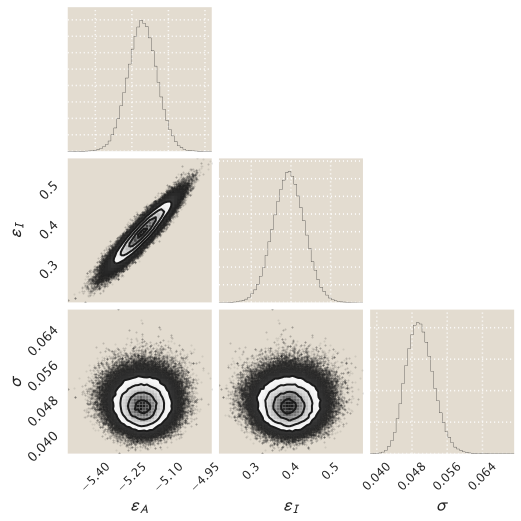

In [79]:
# Load the flat-chain
with open('../../data/mcmc/' + today + \
                  '_gauss_O1_RBS1027newcode.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# # Draw the corner plot
fig = corner.corner(gauss_flatchain, bins=50, plot_contours=True,
                    labels=[r'$\epsilon_A$', r'$\epsilon_I$', r'$\sigma$'])

## Determinine credible region using MCMC traces

To report the output of the MCMC routine we will use the HPD. As explained in [this tutorial](http://bebi103.caltech.edu/2015/tutorials/l06_credible_regions.html)
>This method uses the highest posterior density interval, or HPD. If we're considering a 95% confidence interval, the HPD interval is the shortest interval that contains 95% of the probability of the posterior. So, we report the mode and then the bounds on the HPD interval.

We will use the same funciton used in the tutorial to compute the HPD from the MCMC chain. Now that we not only know the MAP value of the MWC parameters, but also the credible intervals for them we can properly reflect that uncertainty on our plots.

Drawing a proper credible region on the fold-change curve is not as straight forwared as taking both lower and upper boundaries of the HPD and plotting these values since, as shown in the MCMC trace plot the paraemeters are clearly correlated. But we can take advantage of the MCMC traces to compute the proper credible intevals. We use the function 'mcmc_cred_region' in our mwc_utils to calculate this credible region.

Now lets calculate the HPD from the MCMC traces for each of our strains. We'll create a new Pandas DataFrame to save these in for plotting.

In [140]:
# generate DataFrame to save parameter estimates

# Loop through each strain in groups and calculate HPD
groups = df.groupby(['operator', 'rbs'])
for g, subdata in groups:
    if g[0] == 'Oid':
        continue
    with open('../../data/mcmc/' + '20170109' + \
              '_gauss_homoscedastic_' + g[0] + '_' + g[1] + '.pkl', 'rb') as file:
        unpickler = pickle.Unpickler(file)
        gauss_flatchain = unpickler.load()
        gauss_flatlnprobability = unpickler.load()
    
    # map value of the parameters
    max_idx = np.argmax(gauss_flatlnprobability, axis=0)
    ea, ei = gauss_flatchain[max_idx, [0, 1]]

    # ea range
    ea_hpd = mwc.hpd(gauss_flatchain[:, 0],0.95)
    ei_hpd = mwc.hpd(gauss_flatchain[:, 1],0.95)
              
    # add values to dataframe
    param_summary_temp = pd.DataFrame({'rbs':g[1],
                                'operator':g[0],
                                'repressors':df[df['rbs']==g[1]].repressors.unique()[0],
                                'ka_mode':[ea],
                                'ka_hpd_max':[ea_hpd[0]],
                                'ka_hpd_min':[ea_hpd[1]],
                                'ki_mode':[ei],
                                'ki_hpd_max':[ei_hpd[0]],
                                'ki_hpd_min':[ei_hpd[1]]})

    param_summary = param_summary.append(param_summary_temp, ignore_index=True)

# Plot the results

Here we will want to plot the parameter estimates of $K_A$ and $K_I$. We will also want to use these parameter estimates to predict fold-change as a function of operator binding energy and LacI copy number. Due to the many possible combinations of operator and LacI copy number, we consider each set of strains with a common operator.

In [145]:
# Pick operator to look at.
op = 'O1'

df_plot = df[df.operator==op]
param_summary_op= param_summary[param_summary.operator==op]

Lets first plot the estimates of $K_A$ and $K_I$. We also want to include the inferred values for $K_A$ and $K_I$ from the global inference. From the MCMC_parameter_estimation notebook, we found:


In [152]:
with open('../../data/mcmc/' + 'pool_data' + '.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
Ka_global, Ki_global = np.exp(-gauss_flatchain[max_idx, [0, 1]])

# ea range
Ka_global_range = np.exp(-mwc.hpd(gauss_flatchain[:, 0],0.95))
Ki_global_range =np.exp(-mwc.hpd(gauss_flatchain[:, 1],0.95))

Lets start by plotting the inferred values for $K_A$ and $K_I$ across each strain with a different copy number of LacI.

In [143]:
# Define array of IPTG concentrations
IPTG = np.logspace(-9, -1, 200)

# current default color palette
colors = sns.color_palette('colorblind', n_colors=8)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]
gs_dict = {'hspace': 0.1, 'wspace':0.1}

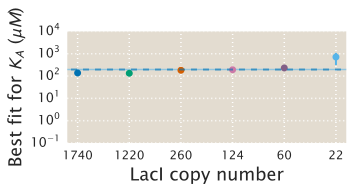

In [153]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,2), gridspec_kw=gs_dict)


for i, rbs_fit in enumerate(df.rbs.unique()):
    Ka = np.exp(-param_summary_op[param_summary_op['rbs']==rbs_fit].ka_mode)
    Ka_hpd_max = np.exp(-param_summary_op[param_summary_op['rbs']==rbs_fit].ka_hpd_max)
    Ka_hpd_min = np.exp(-param_summary_op[param_summary_op['rbs']==rbs_fit].ka_hpd_min)

    plt.errorbar(i,Ka, 
                 yerr=[np.abs(Ka-Ka_hpd_min.values[0]),np.abs(Ka-Ka_hpd_max.values[0])],
                 fmt='o', color=colors[i])

# Lets also plot the global best value of Ki using all 
# data across all operators
plt.plot(np.arange(-2,7),np.ones(9)*Ka_global, linestyle='--',alpha=0.6)
plt.fill_between(np.arange(-2,7) , Ka_global_range[0], Ka_global_range[1],
                         alpha=0.5, color=colors[i])

ax.set_yscale('log')
plt.xticks(np.arange(0,6), 2*df.repressors.unique())#, rotation='vertical')
plt.xlim(-0.2,5.2)
plt.ylim(1E-1,1E4)
plt.ylabel('Best fit for $K_A$ ($\mu M$)')
plt.xlabel('LacI copy number')
# plt.savefig('../../data/mcmc/' + date + \
#            '_Ka_summary_' + op + '_wglobal.pdf',bbox_inches='tight')

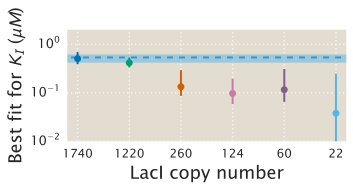

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,2), gridspec_kw=gs_dict)

for i, rbs_fit in enumerate(df.rbs.unique()):
    
    Ki = param_summary_op[param_summary_op['rbs']==rbs_fit].Ki
    Ki_hpd = param_summary_op[param_summary_op['rbs']==rbs_fit].Ki_hpd

    plt.errorbar(i,Ki, 
                 yerr=[np.abs(Ki-Ki_hpd.values[0][1]),np.abs(Ki-Ki_hpd.values[0][0])],
                 fmt='o', color=colors[i])

# Lets also plot the global best value of Ki using all 
# data across all operators
plt.plot(np.arange(-2,7),np.ones(9)*Ki_global, linestyle='--',alpha=0.6)
plt.fill_between(np.arange(-2,7) , Ki_global_range[0], Ki_global_range[1],
                         alpha=0.5, color=colors[i])

ax.set_yscale('log')
plt.xticks(np.arange(0,6), 2*df.repressors.unique())#, rotation='vertical')
plt.xlim(-0.2,5.2)
plt.ylim(1E-2,2)
plt.ylabel('Best fit for $K_I$ ($\mu M$)')
plt.xlabel('LacI copy number')
plt.savefig('../../data/mcmc/' + date + \
           '_Ki_summary_' + op + '_wglobal.pdf',bbox_inches='tight')

Now lets plot the fold-change predictions and data using the strain specific estimates of $K_A$ and $K_I$.

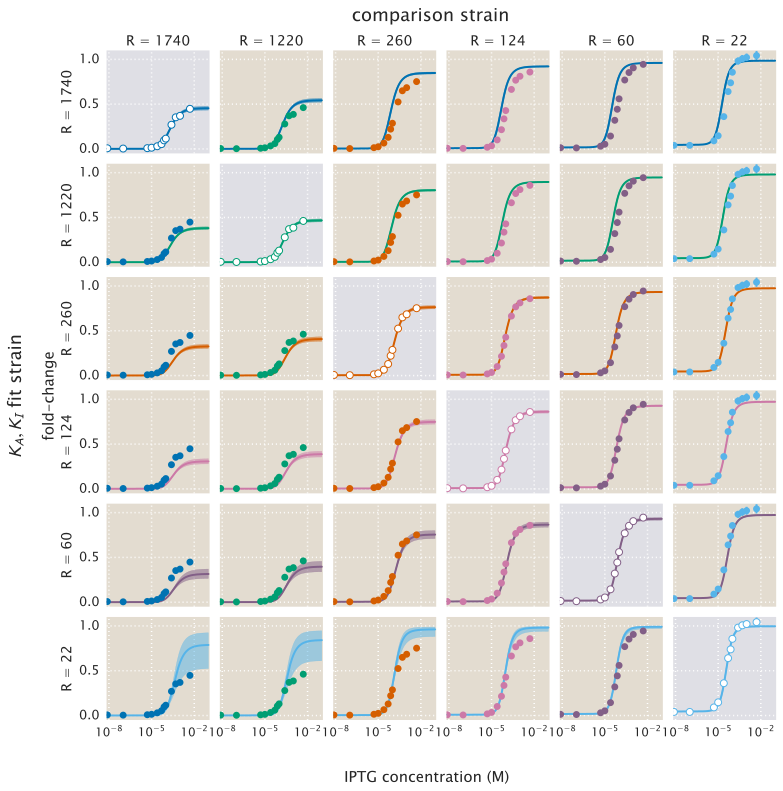

In [19]:

fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(12,12), gridspec_kw=gs_dict)
count = 1
for j, rbs_fit in enumerate(df.rbs.unique()):
    
    with open('../../data/mcmc/' + '20170109' + \
          '_gauss_homoscedastic_' + op + '_' + rbs_fit + '.pkl', 'rb') as file:
        unpickler = pickle.Unpickler(file)
        gauss_pool_flatchain = unpickler.load()

    
    # map value of the parameters
    ea, ei = np.mean(gauss_pool_flatchain[:, [0, 1]], axis=0)

    for i, rbs in enumerate(df.rbs.unique()):
        # plot the theory using the parameters from the fit.
        ax[j,i].plot(IPTG , mwc.fold_change_log(IPTG * 1E6, 
            ea=ea, ei=ei, epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique(),
            epsilon_r=df.binding_energy.unique()),
            color=colors[j])
        # plot 95% HPD region using the variability in the MWC parameters
        cred_region = mwc.mcmc_cred_region(IPTG * 1E6, 
            gauss_pool_flatchain, epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique(),
            epsilon_r=df.binding_energy.unique())
        ax[j,i].fill_between(IPTG , cred_region[0,:], cred_region[1,:],
                        alpha=0.5, color=colors[j])
        # compute the mean value for each concentration
        fc_mean = df[df.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
        # compute the standard error of the mean
        fc_err = df[df.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
        np.sqrt(df[df.rbs==rbs].groupby('IPTG_uM').size())

        # plot the experimental data
        if i == j:
            ax[j,i].errorbar(np.sort(df[df.rbs==rbs].IPTG_uM.unique()) / 1E6, fc_mean,
                yerr=fc_err, linestyle='none', label=rbs, color=colors[i])
            ax[j,i].plot(np.sort(df[df.rbs==rbs].IPTG_uM.unique()) / 1E6, fc_mean,
                        'o', markeredgewidth=1, markeredgecolor=colors[i],
                         markerfacecolor='w', markersize=7)
            ax[j,i].set_axis_bgcolor("#DFDFE5")
        else:
            ax[j,i].errorbar(np.sort(df[df.rbs==rbs].IPTG_uM.unique()) / 1E6, fc_mean,
                yerr=fc_err, fmt='o', markersize=7, label=rbs, color=colors[i])
               
        if i == 0:
            ax[j,i].set_ylabel('R = %s' %(df[df.rbs==rbs_fit].repressors.unique()[0] * 2), fontsize=14)
        if j == 0:
            ax[j,i].set_title('R = %s' %(df[df.rbs==rbs].repressors.unique()[0] * 2), fontsize=14)
        
        ax[j,i].set_xlim(left=-5E-9)
        ax[j,i].set_ylim(-0.05,1.1) 
        ax[j,i].set_xscale('symlog', linthreshx=1E-7)
        ax[j,i].set_xticks([1E-8, 1E-5, 1E-2]) 
        ax[j,i].set_yticks([0, 0.5, 1])
       
        if i > 0 and i < 6 and j < 5:
            ax[j, i].set_xticklabels([])
            ax[j, i].set_yticklabels([])
        if i==0 and j < 5:
            ax[j, i].set_xticklabels([])
        if j==5 and i > 0 and i < 6:
            ax[j, i].set_yticklabels([])

fig.text(0.01, 0.5, '$K_A, K_I$ fit strain', va='center', rotation='vertical',fontsize=18)
fig.text(0.05, 0.5, 'fold-change', va='center', rotation='vertical',fontsize=15)
fig.text(0.4, 0.05, 'IPTG concentration (M)', va='bottom',fontsize=15)
fig.suptitle('comparison strain', y=0.95, fontsize=18)

plt.savefig('../../data/mcmc/' + date + \
         '_fitcompare_summary' + op + '.pdf',bbox_inches='tight')